In [ ]:
!mkdir /content/data
!unzip /content/drive/MyDrive/Kaggle/archive.zip -d /content

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

%cd COVID_CT

/content/COVID_CT


#데이터 읽기 및 폴더 나누기

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [4]:
infected_folder = 'Infected'
infected_images = load_images_from_folder(infected_folder)
n_infected_folder = 'Not_Infected'
n_infected_images = load_images_from_folder(n_infected_folder)

In [5]:
import random
random.seed(12345)

random.shuffle(n_infected_images)
random.shuffle(infected_images)

In [6]:
itr = round(501*0.5)
ival = round(501*0.1)
ite = round(501*0.4)

ntr = round(550*0.5)
nval = round(550*0.1)
nte = round(550*0.4)

In [7]:
covid_dir = 'Covid_CT'
os.mkdir(covid_dir)

In [8]:
# train, val, test folder
train_dir = './Covid_CT/train'
val_dir = './Covid_CT/val'
test_dir = './Covid_CT/test'

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

# infected folder
in_train = './Covid_CT/train/infected'
in_val = './Covid_CT/val/infected'
in_test = './Covid_CT/test/infected'

os.mkdir(in_train)
os.mkdir(in_val)
os.mkdir(in_test)

#not infected folder
not_in_train = './Covid_CT/train/Not_infected'
not_in_val = './Covid_CT/val/Not_infected'
not_in_test = './Covid_CT/test/Not_infected'

os.mkdir(not_in_train)
os.mkdir(not_in_val)
os.mkdir(not_in_test)

In [9]:
def infected_images_to_folder(infected_images, train_dir, val_dir, test_dir):
    for i in range(len(infected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, itr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), infected_images[i])
        elif i in range(itr+1, itr+ival+1):
            cv2.imwrite(os.path.join(val_dir, img_name), infected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), infected_images[i])

In [10]:
def not_infected_images_to_folder(n_intected_images, train_dir, val_dir, test_dir):
    for i in range(len(n_intected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, ntr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), n_intected_images[i])
        elif i in range(ntr+1, ntr+nval+1):
            cv2.imwrite(os.path.join(val_dir, img_name), n_intected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), n_intected_images[i])

In [11]:
infected_images_to_folder(infected_images, './Covid_CT/train/infected', './Covid_CT/val/infected', './Covid_CT/test/infected')
not_infected_images_to_folder(n_infected_images, './Covid_CT/train/Not_infected', './Covid_CT/val/Not_infected', './Covid_CT/test/Not_infected')

# CNN2
+ 1. train 비율을 낮추고 test 비율 높이기
+ 2. drop out 추가 및 마지막 Dense node 수 down

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 30,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (256, 256),
    batch_size = 30,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    batch_size = 30,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

Found 738 images belonging to 2 classes.
Found 105 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


In [14]:
IMAGE_ROWS = 256
IMAGE_COLS = 256
BATCH_SIZE = 30
IMAGE_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE))
model_CNN2.add(layers.MaxPool2D((2,2)))
model_CNN2.add(layers.Dropout(0.5))
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPool2D((2,2)))
model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(64, activation='relu'))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [16]:
from tensorflow.keras import optimizers

model_CNN2.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [17]:
history = model_CNN2.fit_generator(train_generator, steps_per_epoch=1, epochs=10, validation_data=validation_generator, validation_steps=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 32s 32s/step - loss: 0.6718 - acc: 0.6333 - val_loss: 0.5861 - val_acc: 0.6333
Epoch 2/10
1/1 [==============================] - 0s 449ms/step - loss: 0.8074 - acc: 0.6333 - val_loss: 0.6024 - val_acc: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 461ms/step - loss: 0.6749 - acc: 0.7000 - val_loss: 0.5206 - val_acc: 0.8000
Epoch 4/10
1/1 [==============================] - 0s 442ms/step - loss: 0.4382 - acc: 0.7333 - val_loss: 0.4646 - val_acc: 0.7000
Epoch 5/10
1/1 [==============================] - 0s 441ms/step - loss: 0.3548 - acc: 0.8000 - val_loss: 0.3860 - val_acc: 0.7667
Epoch 6/10
1/1 [==============================] - 0s 439ms/step - loss: 0.5342 - acc: 0.5667 - val_loss: 0.3393 - val_acc: 0.9000
Epoch 7/10
1/1 [==============================] - 0s 443ms/step - loss: 0.1661 - acc: 1.0000 - val_loss: 0.3253 - val_acc: 0.9667
Epoch 8/10
1/1 [==============================] - 0s 454ms/step - loss: 0.1956 - acc: 1.000

In [18]:
tr_score = model_CNN2.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train Loss : 0.2268
Train Accuracy : 1.0000


In [19]:
tr_score = model_CNN2.evaluate_generator(test_generator)
print('Test Loss : {:.4f}'.format(tr_score[0]))
print('Test Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss : 0.2331
Test Accuracy : 1.0000


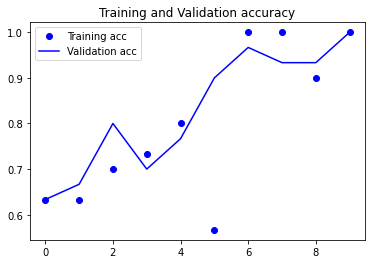

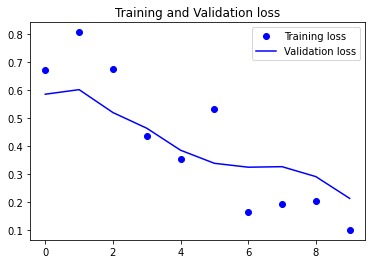

In [20]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

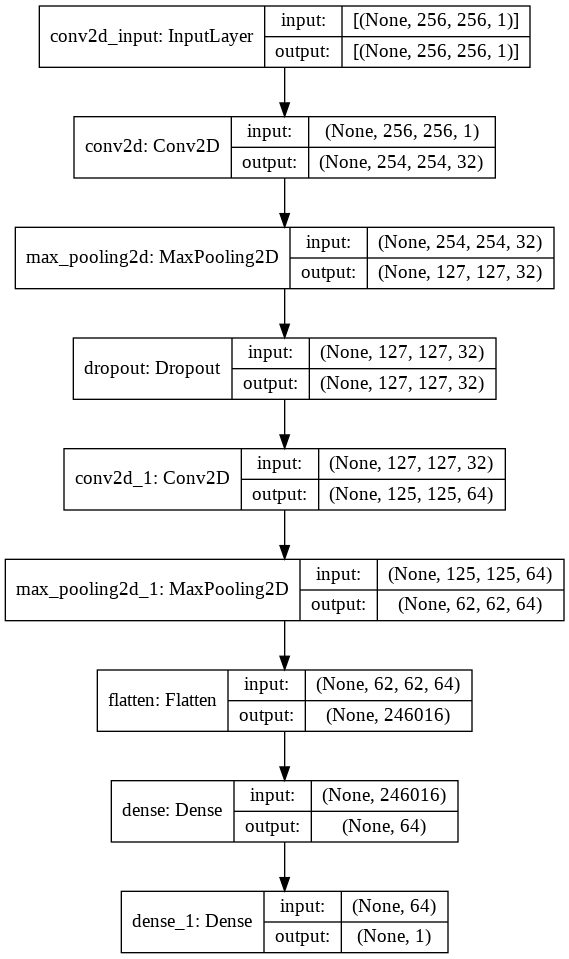

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model_CNN2, to_file='CNN2.png', show_shapes=True)

# CNN3
+ Augmentation

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
vali_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size = 30,
    class_mode='binary',
    color_mode='grayscale'
)

validation_generator = vali_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary',
    color_mode='grayscale'
)

Found 738 images belonging to 2 classes.
Found 105 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


In [26]:
IMAGE_ROWS = 150
IMAGE_COLS = 150
BATCH_SIZE = 30
IMAGE_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

In [29]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE))
model_CNN3.add(layers.MaxPool2D((2,2)))
model_CNN3.add(layers.Dropout(0.5))
model_CNN3.add(layers.Conv2D(64, (3,3), activation='relu'))
model_CNN3.add(layers.MaxPool2D((2,2)))
model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dropout(0.5))
model_CNN3.add(layers.Dense(64, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 82944)            

In [31]:
from tensorflow.keras import optimizers

model_CNN3.compile(optimizer=optimizers.Adam(1e-4), 
                   loss = 'binary_crossentropy',
                   metrics=['acc'])

In [33]:
history = model_CNN3.fit_generator(train_generator, steps_per_epoch=15, epochs=10, validation_data=validation_generator, validation_steps=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
15/15 [==============================] - 4s 192ms/step - loss: 0.6878 - acc: 0.5228 - val_loss: 0.6486 - val_acc: 0.5667
Epoch 2/10
15/15 [==============================] - 3s 176ms/step - loss: 0.6618 - acc: 0.5778 - val_loss: 0.6527 - val_acc: 0.4333
Epoch 3/10
15/15 [==============================] - 3s 181ms/step - loss: 0.6667 - acc: 0.5662 - val_loss: 0.6386 - val_acc: 0.8000
Epoch 4/10
15/15 [==============================] - 3s 178ms/step - loss: 0.6294 - acc: 0.6073 - val_loss: 0.6174 - val_acc: 0.7667
Epoch 5/10
15/15 [==============================] - 3s 182ms/step - loss: 0.6408 - acc: 0.6133 - val_loss: 0.5955 - val_acc: 1.0000
Epoch 6/10
15/15 [==============================] - 3s 175ms/step - loss: 0.5903 - acc: 0.6918 - val_loss: 0.5601 - val_acc: 0.8000
Epoch 7/10
15/15 [==============================] - 3s 180ms/step - loss: 0.5978 - acc: 0.6756 - val_loss: 0.6322 - val_acc: 0.7000
Epoch 8/10
15/15 [==============================] - 3s 174ms/step - loss: 0.

In [34]:
tr_score = model_CNN3.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train Loss : 0.5933
Train Accuracy : 0.6802


In [35]:
tr_score = model_CNN3.evaluate_generator(test_generator)
print('Test Loss : {:.4f}'.format(tr_score[0]))
print('Test Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss : 0.5104
Test Accuracy : 0.7837


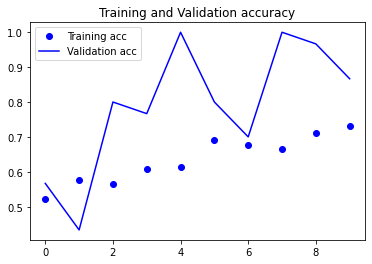

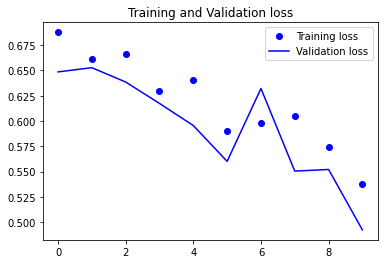

In [38]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

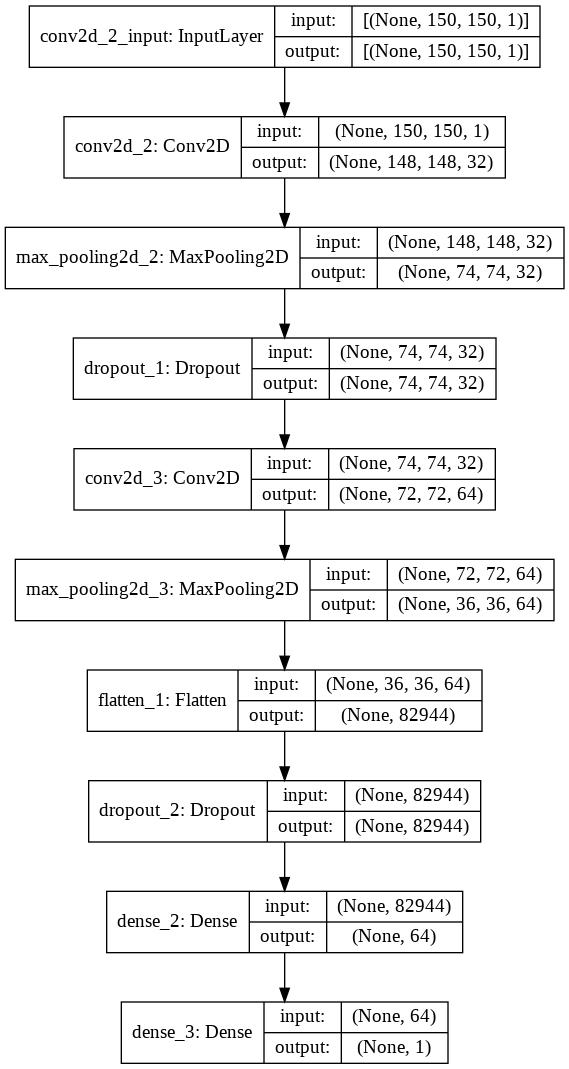

In [44]:
from tensorflow.keras.utils import plot_model

plot_model(model_CNN3, to_file='/content/1.jpg', show_shapes=True)

# Augmented Data 확인

In [48]:
import os
from tensorflow.keras.preprocessing import image

train_dir = '/content/COVID_CT/Covid_CT/train'
one_fname = os.path.join(str(train_dir + '/infected/202.jpg'))
img = image.load_img(one_fname, target_size=(258,258))

In [49]:
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

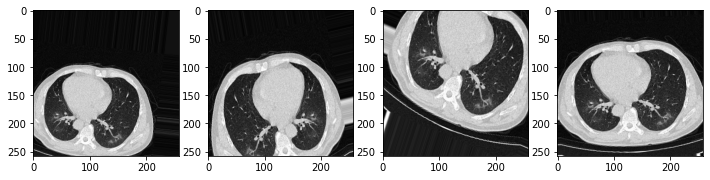

In [50]:

i = 0
plt.figure(figsize=(12,6))

for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(1, 4,i+1)
    plt.imshow(image.array_to_img(batch[0]))

    i += 1
    if i % 4 == 0:
        break

plt.show()